# Natural Language Processing Sentiment Analysis Mini-Project

## Problem Description

In particular, the problem posed by the dataset of movie reviews is one of binary classification: i.e., a review is either positive or negative, not both nor neither. If a third class was to exist for this task, then multi-class or regression (if the task was the predict the value of this third class) approaches would be more suitable. 

To proceed with a structured approach, it is useful to consider the NLP pipeline(s) which consists of three steps: text processing, feature extraction, and modelling. A further decomposition of these three steps gives the following five steps: analysis of task and framework definition; pre-processing data; definition and extraction of relevant information; selection and implementation of an appropriate algorithm; application and evaluation of algorithm. These five steps shall be clearly illustrated throughout the notebook with the use of headings. A topic of note with respect to the pipeline is that it behaves much like a cycle, as after evaluation, it is often the case that improvements can be made that improve accuracy, precision, or recall. 

## Method

### Step 1: Choosing the correct framework and analysis of task

This was completed by reading the task description given thoroughly as well as a manual inspection of the dataset itself, as reviews were inputted as notepad files. It became clear that this was a data-heavy process, which would require a suitable environment such as a notebook to work in, allowing for cells to be executed individually, saving time and effort. Hence, the notebook was set up and initial functions were written to obtain the files themselves, and organise data into a DataFrame, from where it could be later read and transformed as needed. As classification into either a “positive” or “negative” class was needed, a column called “sentiment” was created to make this obvious, and easier for calculation.  

## Import modules

In [1]:
import re
import numpy as np
import pandas as pd
import nltk
import string
import os, glob
import spacy
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.layers import LSTM

from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing.text import one_hot
from tensorflow.keras.layers import Embedding
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.utils import pad_sequences
from keras.layers import GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras import optimizers
optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)

from numpy import array
from numpy import asarray
from numpy import zeros

load_model = spacy.load('en_core_web_sm', disable = ['parser','ner'])
nltk.download('punkt')
my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2)]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vedan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Step 2: Pre-Processing

Multiple columns were necessary for the dataframe- at least four were required: one for IDs, rating, sentiment, and the text itself. From lectures, further research and manual reading of a few reviews, it was clear that some level of pre-processing was required before algorithms could make use of the data. 

In [ ]:
ids, ratings, sent, cleaned, nltk_stem, nltk_lem, spacy_lem, raw, postag, pos_tag_nltk_stem, pos_tag_nltk_lem, pos_tag_spacy_lemmatize = [], [], [], [], [], [], [], [], [], [], [], []
columns = ['id', 'rating', 'sentiment', 'raw', 'cleaned', 'nltk_stem', 'nltk_lem', 'spacy_lem', 'pos_tag']

stoplist = set(stopwords.words('english'))
sent.extend([1] * 2000)
sent.extend([0] * 2000)

# read files
def read_folder(path):
    read_files(str(path) + "neg")
    read_files(str(path) + "pos")
    

def read_files(path):
    for file in os.listdir(path):
        if file.endswith(".txt"):
            with open(f"{path}\{file}", 'r', encoding="utf8") as f:
                name = os.path.basename(f"{path}\{file}").split("_")
                ids.append(int(name[0]))
                ratings.append(int(name[1].split(".")[0]))
                text = f.read()
                raw.append(text)
                cln_text = clean_text(text)
                posttag_text = clean_text(str(postagger(text)))
                cleaned.append(cln_text)
                nltk_stem.append(' '.join(nltk_stemmer(cln_text)))
                nltk_lem.append(' '.join(nltk_lemmatizer(cln_text)))
                spacy_lem.append(' '.join(spacy_lemmatize(cln_text)))
                postag.append(posttag_text)
    return True

There were many examples of spam such as br tags, which are the by-product of HTML code for paragraph breaks. It is rare for these tags to contain information themselves, and only exist to make text easier to read for human readers: computers are unaffected by visual readability. In addition to this, punctuation contains very little meaning so this must be filtered out too. Extra spaces next to words are also removed twice over to ensure all inconsistencies are removed. As there were many features to get rid of, it was deemed necessary to create a function called “clean_text” which would take text as it was being read from the file and apply regular expressions to remove useless or outlier data such as numbers, or stopwords, along with the aforementioned terms. 

In [ ]:
def clean_text(text):
    text = text.lower().replace("<br />", "")
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)
    text = re.sub(r'\s+', ' ', text)
    return str(text)

### Step 3: Definition and Extraction

For this step, PoS tagging has been implemented, and another set of columns were added to the dataframe containing the list of results which corresponds to this. It is also crucial that PoS tagging is applied before the text is cleaned with regular expressions and the removal of stopwords: this would otherwise inhibit the full effectiveness of the PoS tagging, as the algorithm relies on using these features to make predictions about the type of word it is identifying. Hence, the PoS is applied first, then the text is cleaned, followed by an application to all morphological columns that apply stemming and lemming. 

PoS has been trialled in two ways: it was initially thought that reducing the number of words and increasing the number of adjectives could enhance the model’s accuracy. With testing, it was clear that this was not the case, so this was then generalised to include nouns and verbs. This improved all the scores across the board slightly as shown here, but added a slight curve to the graphs shown in the notebook. 


In [2]:
# PoS tag adjectives, nouns, adverbs, verbs, and wh-adverbs
def postagger(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    filtered_tags = []
    for (word, tag) in tagged:
        if ("JJ" in tag or "NN" in tag or "RB" in tag or "VB" in tag or "WRB" in tag):
        # if ("JJ" in tag or "RB" in tag):
            filtered_tags.append(word)
    return filtered_tags


# nltk tokenizer + nltk stemmer
def nltk_stemmer(text):
    word_list = ""
    st = LancasterStemmer()
    word_list = [st.stem(word) for word in word_tokenize(text)
             if not word in stoplist and not word in string.punctuation]
    return word_list
    
# nltk tokenizer + nltk lemmatizer
def nltk_lemmatizer(text):
    word_list = ""
    lemmatizer = WordNetLemmatizer()
    word_list = [lemmatizer.lemmatize(word) for word in word_tokenize(text)
             if not word in stoplist and not word in string.punctuation]
    return word_list

def spacy_lemmatize(text):    
    word_list = []
    model = load_model(text)
    for tn in model:
        if tn.is_stop == False:
            word_list.append(tn.lemma_)
    return word_list
    
def arrtostr(arr):
    return ' '.join(arr)

def main():
    path = "C:/Users/vedan/"
    read_folder(path)
    
    df = pd.DataFrame(np.array([ids, ratings, sent, raw, cleaned, nltk_stem, nltk_lem, spacy_lem, postag]).T, columns=columns)
    df['pos_tag_nltk_stem'] = (df['pos_tag'].map(nltk_stemmer))
    df['pos_tag_nltk_lem'] = (df['pos_tag'].map(nltk_lemmatizer))
    df['pos_tag_spacy_lemmatize'] = (df['pos_tag'].map(spacy_lemmatize))
        
    df['pos_tag_nltk_stem'] = (df['pos_tag_nltk_stem'].map(arrtostr))
    df['pos_tag_nltk_lem'] = (df['pos_tag_nltk_lem'].map(arrtostr))
    df['pos_tag_spacy_lemmatize'] = (df['pos_tag_spacy_lemmatize'].map(arrtostr))
    
    # shuffle the dataframe
    df = df.sample(frac = 1)
    
    return df

df = main()

In [3]:
# this is the dataframe
df

,id,rating,sentiment,raw,cleaned,nltk_stem,nltk_lem,spacy_lem,pos_tag,pos_tag_nltk_stem,pos_tag_nltk_lem,pos_tag_spacy_lemmatize
566,2013,3,1,This film is roughly what it sounds like: a fu...,this film is roughly what it sounds like futur...,film rough sound lik fut vert cinderell legend...,film roughly sound like futuristic version cin...,film roughly sound like futuristic version cin...,film is roughly sounds futuristic version cin...,film rough sound fut vert cinderell legend son...,film roughly sound futuristic version cinderel...,film roughly sound futuristic version cinder...
458,1430,1,1,While flipping through the channels on a late ...,while flipping through the channels on late sa...,flip channel lat saturday night friend stumbl ...,flipping channel late saturday night friend st...,flip channel late saturday night friend stumbl...,flipping channels late saturday night friends...,flip channel lat saturday night friend stumbl ...,flipping channel late saturday night friend st...,flip channel late saturday night friend stum...
1158,5331,1,1,"Without question, the worst ELVIS film ever ma...",without question the worst elvis film ever mad...,without quest worst elv film ev mad movy portr...,without question worst elvis film ever made mo...,question bad elvis film movie portray indians ...,question worst elvis film ever made movie por...,quest worst elv film ev mad movy portray ind d...,question worst elvis film ever made movie port...,question bad elvis film movie portray indian...
3814,8969,7,0,Stewart is a distinguished bachelor and a succ...,stewart is distinguished bachelor and successf...,stewart distinct bachel success execut marry f...,stewart distinguished bachelor successful exec...,stewart distinguish bachelor successful execut...,stewart is distinguished bachelor successful ...,stewart distinct bachel success execut marry f...,stewart distinguished bachelor successful exec...,stewart distinguish bachelor successful exec...
2457,1317,8,0,This anime was underrated and still is. Hardly...,this anime was underrated and still is hardly ...,anim under stil hard dorky kid movy not stil c...,anime underrated still hardly dorky kid movie ...,anime underrated hardly dorky kid movie note c...,anime was underrated still is hardly dorky ki...,anim under stil hard dorky kid movy not stil c...,anime underrated still hardly dorky kid movie ...,anime underrate hardly dorky kid movie note ...
...,...,...,...,...,...,...,...,...,...,...,...,...
850,360,4,1,I read the book and really enjoyed it from beg...,i read the book and really enjoyed it from beg...,read book real enjoy begin end howev saw movy ...,read book really enjoyed beginning end however...,read book enjoy begin end see movie disappoint...,read book really enjoyed beginning end howeve...,read book real enjoy begin end howev saw movy ...,read book really enjoyed beginning end however...,read book enjoy begin end saw movie disappoi...
2806,3251,7,0,"Yet another remake of ""Fistful of Dollars"", Se...",yet another remake of fistful of dollars sergi...,yet anoth remak fist doll sergio leon remak ku...,yet another remake fistful dollar sergio leone...,remake fistful dollar sergio leone remake kuro...,yet remake fistful dollars sergio leone remak...,yet remak fist doll sergio leon remak kurosaw ...,yet remake fistful dollar sergio leone remake ...,remake fistful dollar sergio leone remake ku...
2269,11495,10,0,We saw this at one of the local art movie thea...,we saw this at one of the local art movie thea...,saw on loc art movy the montros are houston tx...,saw one local art movie theater montrose area ...,see local art movie theater montrose area hous...,saw local art movie theaters montrose area ho...,saw loc art movy the montros are houston tx to...,saw local art movie theater montrose area hous...,see local art movie theater montrose area ho...
2641,2346,9,0,Very sweet pilot. The show reeks of Tim Burton...,very sweet pilot the show reeks of tim burton ...,sweet pilot s

In [4]:
for col in df.columns[3:]:
    print(col, "text length =",len(df[col][0]))

raw text length = 1506
cleaned text length = 1359
nltk_stem text length = 678
nltk_lem text length = 817
spacy_lem text length = 672
pos_tag text length = 978
pos_tag_nltk_stem text length = 648
pos_tag_nltk_lem text length = 783
pos_tag_spacy_lemmatize text length = 649


The cumulative frequencies of all words have been calculated to identify the most common words. The calculation has also been applied to the “raw” column, but this is more for providing a “control” test rather than a usable piece of information. The intention of drawing all the graphs for all columns is to illustrate Zipf’s Law at work (Piantadosi, S.T., 2014). It suggests that the frequency of any word in a text is inversely proportional to the rank it holds in a frequency table- essentially the more often a word appears, the more useless becomes as a factor to classify a text. 

From the graphs visible, one can see the change from a Zipfian curve to a more linear graph- which is more appropriate for classification. In both the raw and cleaned texts, it makes sense that there is a curve, as no stopwords or phrases have yet been removed. It is however, when stemming and lemmatisation is done where the stopwords such as “the” and “it” get removed, and the graph starts to straighten up. This implies that the functions are operating as intended. In addition to this, one can see as an example, the first review goes from 1506 words to a length of 649 words after PoS tagging, cleaning, and lemmatisation has been applied. 

Piantadosi, S.T., 2014. Zipf’s word frequency law in natural language: A critical review and future directions. Psychonomic bulletin & review, 21(5), pp.1112-1130. 


Frequencies for column name raw in dataframe
[(',', 12), ('<', 10), ('br', 10), ('/', 10), ('>', 10), ('the', 6), ('is', 5), ('.', 4), ('your', 4), ('of', 4), ('I', 3), ('this', 3), ('here', 3), ('in', 3), ('just', 3), ('and', 3), ('college', 3), ('to', 3), ('with', 2), ('a', 2), ('...', 2), ('heroine', 2), ('who', 2), ('slasher', 2), ('you', 2), ('This', 2), ('that', 2), ('off', 2), ('students', 2), ('have', 2), ("''", 2), ('am', 1), ('starting', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('about', 1), ('film', 1), ('Do', 1), ('not', 1), ('read', 1), ('further', 1), ('it', 1), ('comes', 1), ('avert', 1), ('eyes', 1), ('!', 1), ('The', 1), ('main', 1)]


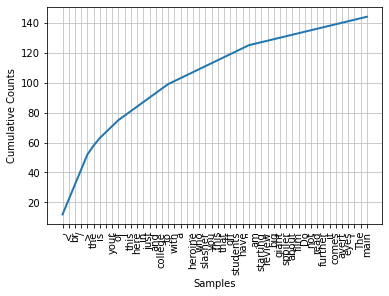

Frequencies for column name cleaned in dataframe
[('the', 7), ('this', 5), ('is', 5), ('your', 4), ('of', 4), ('here', 3), ('in', 3), ('just', 3), ('and', 3), ('college', 3), ('to', 3), ('with', 2), ('do', 2), ('heroine', 2), ('who', 2), ('slasher', 2), ('you', 2), ('life', 2), ('that', 2), ('off', 2), ('students', 2), ('have', 2), ('i', 1), ('am', 1), ('starting', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('about', 1), ('film', 1), ('not', 1), ('read', 1), ('further', 1), ('it', 1), ('comes', 1), ('avert', 1), ('eyes', 1), ('main', 1), ('girl', 1), ('always', 1), ('survives', 1), ('other', 1), ('films', 1), ('murdered', 1), ('there', 1), ('saved', 1), ('minutes', 1), ('one', 1), ('those', 1)]


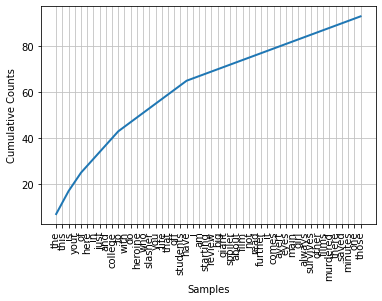

Frequencies for column name nltk_stem in dataframe
[('colleg', 3), ('film', 2), ('com', 2), ('heroin', 2), ('slash', 2), ('lif', 2), ('stud', 2), ('start', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoil', 1), ('read', 1), ('avert', 1), ('ey', 1), ('main', 1), ('girl', 1), ('alway', 1), ('surv', 1), ('murd', 1), ('sav', 1), ('minut', 1), ('on', 1), ('cheap', 1), ('movy', 1), ('thrown', 1), ('togeth', 1), ('middl', 1), ('er', 1), ('despit', 1), ('kil', 1), ('substandard', 1), ('junk', 1), ('priest', 1), ('get', 1), ('bad', 1), ('rap', 1), ('pict', 1), ('oversex', 1), ('sociopath', 1), ('moron', 1), ('way', 1), ('many', 1), ('intern', 1), ('problem', 1), ('deal', 1), ('look', 1), ('lik', 1), ('juny', 1), ('camp', 1)]


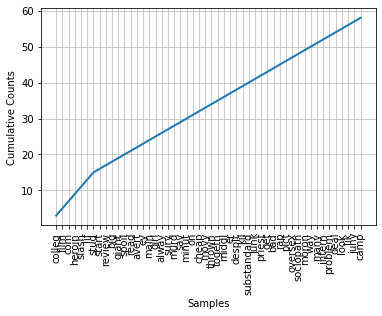

Frequencies for column name nltk_lem in dataframe
[('college', 3), ('film', 2), ('come', 2), ('heroine', 2), ('slasher', 2), ('life', 2), ('student', 2), ('starting', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('read', 1), ('avert', 1), ('eye', 1), ('main', 1), ('girl', 1), ('always', 1), ('survives', 1), ('murdered', 1), ('saved', 1), ('minute', 1), ('one', 1), ('cheap', 1), ('movie', 1), ('thrown', 1), ('together', 1), ('middle', 1), ('era', 1), ('despite', 1), ('killing', 1), ('substandard', 1), ('junk', 1), ('priest', 1), ('get', 1), ('bad', 1), ('rap', 1), ('pictured', 1), ('oversexed', 1), ('sociopathic', 1), ('moron', 1), ('way', 1), ('many', 1), ('internal', 1), ('problem', 1), ('deal', 1), ('look', 1), ('like', 1), ('junior', 1), ('campus', 1)]


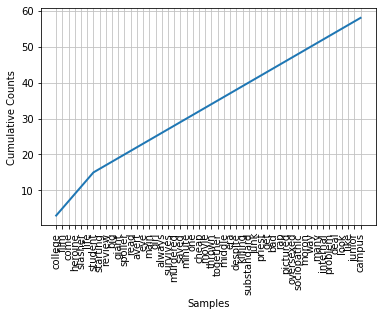

Frequencies for column name spacy_lem in dataframe
[('college', 3), ('film', 2), ('come', 2), ('heroine', 2), ('slasher', 2), ('life', 2), ('student', 2), ('bad', 2), ('start', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('read', 1), ('avert', 1), ('eye', 1), ('main', 1), ('girl', 1), ('survive', 1), ('murder', 1), ('save', 1), ('minute', 1), ('cheap', 1), ('movie', 1), ('throw', 1), ('middle', 1), ('era', 1), ('despite', 1), ('kill', 1), ('substandard', 1), ('junk', 1), ('priest', 1), ('rap', 1), ('picture', 1), ('oversexed', 1), ('sociopathic', 1), ('moron', 1), ('way', 1), ('internal', 1), ('problem', 1), ('deal', 1), ('look', 1), ('like', 1), ('junior', 1), ('campus', 1), ('splatter', 1), ('university', 1), ('gunk', 1), ('vcr', 1), ('well', 1)]


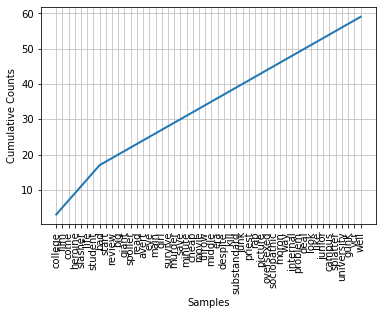

Frequencies for column name pos_tag in dataframe
[('is', 5), ('here', 3), ('just', 3), ('college', 3), ('do', 2), ('heroine', 2), ('slasher', 2), ('life', 2), ('students', 2), ('have', 2), ('am', 1), ('starting', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('film', 1), ('not', 1), ('read', 1), ('further', 1), ('comes', 1), ('avert', 1), ('eyes', 1), ('main', 1), ('girl', 1), ('always', 1), ('survives', 1), ('other', 1), ('films', 1), ('murdered', 1), ('saved', 1), ('minutes', 1), ('cheap', 1), ('movies', 1), ('was', 1), ('thrown', 1), ('together', 1), ('middle', 1), ('era', 1), ('killing', 1), ('off', 1), ('substandard', 1), ('junk', 1), ('both', 1), ('priests', 1), ('get', 1), ('bad', 1), ('rap', 1), ('are', 1), ('pictured', 1)]


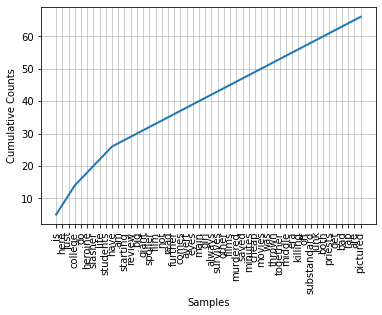

Frequencies for column name pos_tag_nltk_stem in dataframe
[('colleg', 3), ('film', 2), ('com', 2), ('heroin', 2), ('slash', 2), ('lif', 2), ('stud', 2), ('start', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoil', 1), ('read', 1), ('avert', 1), ('ey', 1), ('main', 1), ('girl', 1), ('alway', 1), ('surv', 1), ('murd', 1), ('sav', 1), ('minut', 1), ('cheap', 1), ('movy', 1), ('thrown', 1), ('togeth', 1), ('middl', 1), ('er', 1), ('kil', 1), ('substandard', 1), ('junk', 1), ('priest', 1), ('get', 1), ('bad', 1), ('rap', 1), ('pict', 1), ('oversex', 1), ('sociopath', 1), ('moron', 1), ('way', 1), ('many', 1), ('intern', 1), ('problem', 1), ('deal', 1), ('look', 1), ('juny', 1), ('camp', 1), ('ev', 1), ('wors', 1), ('splatter', 1)]


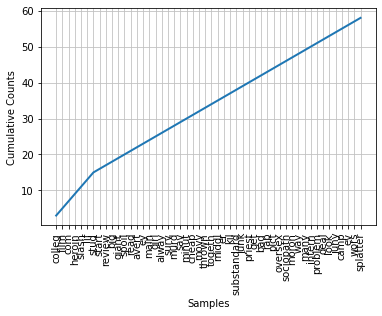

Frequencies for column name pos_tag_nltk_lem in dataframe
[('college', 3), ('film', 2), ('come', 2), ('heroine', 2), ('slasher', 2), ('life', 2), ('student', 2), ('starting', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('read', 1), ('avert', 1), ('eye', 1), ('main', 1), ('girl', 1), ('always', 1), ('survives', 1), ('murdered', 1), ('saved', 1), ('minute', 1), ('cheap', 1), ('movie', 1), ('thrown', 1), ('together', 1), ('middle', 1), ('era', 1), ('killing', 1), ('substandard', 1), ('junk', 1), ('priest', 1), ('get', 1), ('bad', 1), ('rap', 1), ('pictured', 1), ('oversexed', 1), ('sociopathic', 1), ('moron', 1), ('way', 1), ('many', 1), ('internal', 1), ('problem', 1), ('deal', 1), ('look', 1), ('junior', 1), ('campus', 1), ('even', 1), ('worse', 1), ('splatter', 1)]


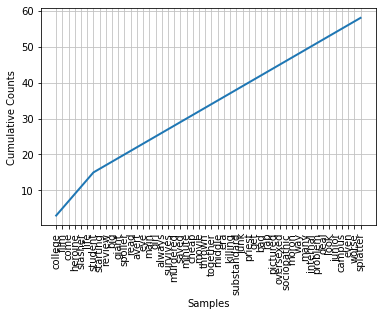

Frequencies for column name pos_tag_spacy_lemmatize in dataframe
[('college', 3), ('film', 2), ('come', 2), ('heroine', 2), ('slasher', 2), ('life', 2), ('student', 2), ('bad', 2), ('start', 1), ('review', 1), ('big', 1), ('giant', 1), ('spoiler', 1), ('read', 1), ('avert', 1), ('eye', 1), ('main', 1), ('girl', 1), ('survive', 1), ('murder', 1), ('save', 1), ('minute', 1), ('cheap', 1), ('movie', 1), ('throw', 1), ('middle', 1), ('era', 1), ('kill', 1), ('substandard', 1), ('junk', 1), ('priest', 1), ('rap', 1), ('picture', 1), ('oversexed', 1), ('sociopathic', 1), ('moron', 1), ('way', 1), ('internal', 1), ('problem', 1), ('deal', 1), ('look', 1), ('junior', 1), ('campus', 1), ('splatter', 1), ('university', 1), ('gunk', 1), ('vcr', 1), ('well', 1), ('suggest', 1), ('watch', 1)]


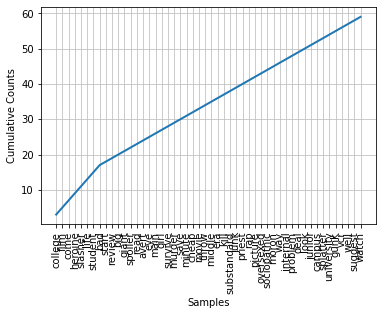

In [5]:
def calcfreq(col):
    corpus = col.values.tolist()
    for review in corpus:
        corpus = [word for word in word_tokenize(review)]
    frequency = nltk.FreqDist(corpus)
    return frequency

for column in df.columns[3:]:
    print("Frequencies for column name",column,"in dataframe")
    frequency = calcfreq(df[column])
    print(frequency.most_common(50))
    frequency.plot(50, cumulative=True)

### Step 4: Selection and Implementation of appropriate algorithms

As information on the labels has been given, and the fact that unsupervised methods take more time and give information on the categories found in data, these types of methods have been kept aside. Lexicon methods are also classified as unsupervised learning (Medhat, W., et al, 2014), so these are also not addressed here. This leaves the options of probabilistic classifiers, rule-based classifiers, linear classifiers, and decision tree classifiers. 

Many research papers, and lectures slides, indicate that Naïve Bayes is a used as a baseline in text classification as it is fast and easy to implement, while working “quite well” in real-world applications (Xu, S., 2018). To describe the Naïve Bayes model, it can be understood as a model which presumes that the inclusion of a feature is independent from of other features (known as the independence assumption). Inherently, this would be a “wrong” assumption, at least within the context of movie reviews: one would expect words such as “terrible” would be accompanied by words such as “bad” instead of “awesome”, however the model often defies this in practicality. However, this still implies failure to correctly classify some data due to the assumption (Xu, S., 2018). In lectures, it has been referred to as 1) a reasonably simple and interpretable algorithm; 2) showing competitive performance in practice. To classify, it evaluates an inequality: if the probability of a class given the content is higher than the second class given same content, it will return the text as an example of the first class. It is often the case that the model must break a piece of text down into individual words, as the occurrence of the same phrase repeatedly in the database is unlikely. To do this, it applies the Bayes theorem, which allows the decomposition of the inequality into prior probabilities and likelihood. The NB algorithm can also accomplish classification with one iteration over the data (Schütze, H., et al, 2008) It is due to this efficiency and accuracy that Naïve Bayes was selected as a baseline. 

Xu, S., 2018. Bayesian Naïve Bayes classifiers to text classification. Journal of Information Science, 44(1), pp.48-59. 
Schütze, H., Manning, C.D. and Raghavan, P., 2008. Introduction to information retrieval (Vol. 39, pp. 234-265). Cambridge: Cambridge University Press. 

Medhat, W., Hassan, A. and Korashy, H., 2014. Sentiment analysis algorithms and applications: A survey. Ain Shams engineering journal, 5(4), pp.1093-1113.

As an alternative comparison model, neural networks were chosen. Specifically, a dense layer; 1D convolutional model; and an LSTM model were implemented in conjunction with the vectorisation algorithm GloVe. The convolutional layer has been used to trial a neural network with more than one activation function, to see how this impacts the results obtained. The final model is an experimental LSTM model (low short term memory) model whose neural layers and numbers have been manually tweaked to try and beat the baseline Naïve Bayes model. On a similar movie sentiment analysis experiment in another paper (Zhou, C., et al, 2015), LSTM has been shown to be 86.6% effective at classifying binary classes. 

Zhou, C., Sun, C., Liu, Z. and Lau, F., 2015. A C-LSTM neural network for text classification. arXiv preprint arXiv:1511.08630. 


### Step 5: Evaluation

#### Count Vectorizer (Bag of Words) Multinomial Naive Bayes Classification

Experimenting with bag of words to vectorise the data and combining with Multinomial Naïve Bayes gives very good results and has been used as a baseline for all testing henceforth. It obtains very good results across the board in all columns, giving out an output an average of 80+% on every statistic. It was the most accurate on pos_tag_nltk_lem and pos_tag_spacy_lem with an accuracy of 82.75%: it makes sense that the pos tag results are higher in general for all statistics, as all noise is being filtered out, leaving only relevant words. Recall is the highest on the raw and cleaned data, which is odd, but in these statistics, precision is lower. Hence the F1 score for most statistics here favours the PoS tagged alternatives. 

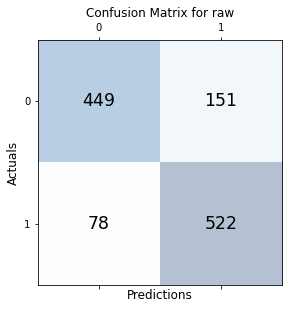

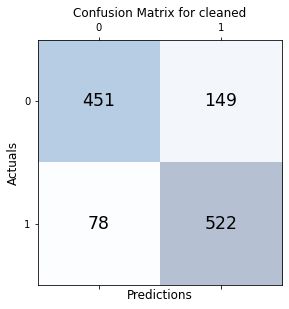

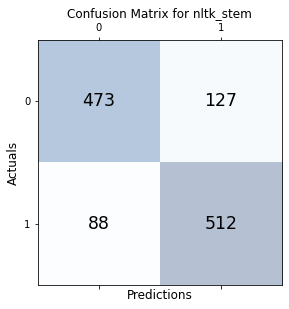

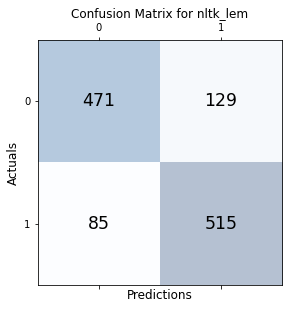

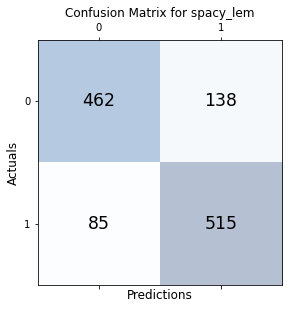

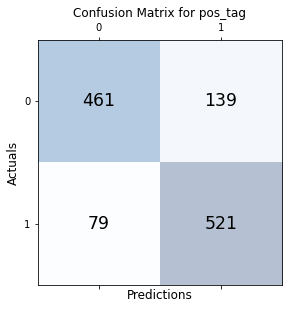

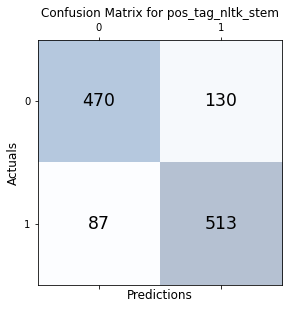

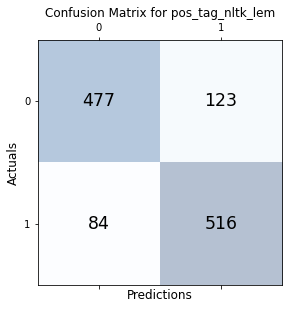

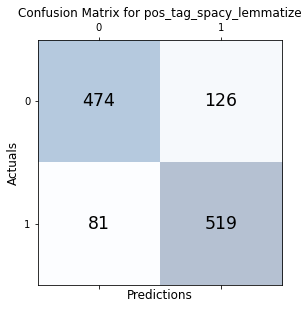

,Text Type,Accuracy,Recall,Precision,F1 Score
0,raw,80.92,87.00,77.56,82.01
1,cleaned,81.08,87.00,77.79,82.14
2,nltk_stem,82.08,85.33,80.13,82.65
3,nltk_lem,82.17,85.83,79.97,82.80
4,spacy_lem,81.42,85.83,78.87,82.20
5,pos_tag,81.83,86.83,78.94,82.70
6,pos_tag_nltk_stem,81.92,85.50,79.78,82.54
7,pos_tag_nltk_lem,82.75,86.00,80.75,83.29
8,pos_tag_spacy_lemmatize,82.75,86.50,80.47,83.37


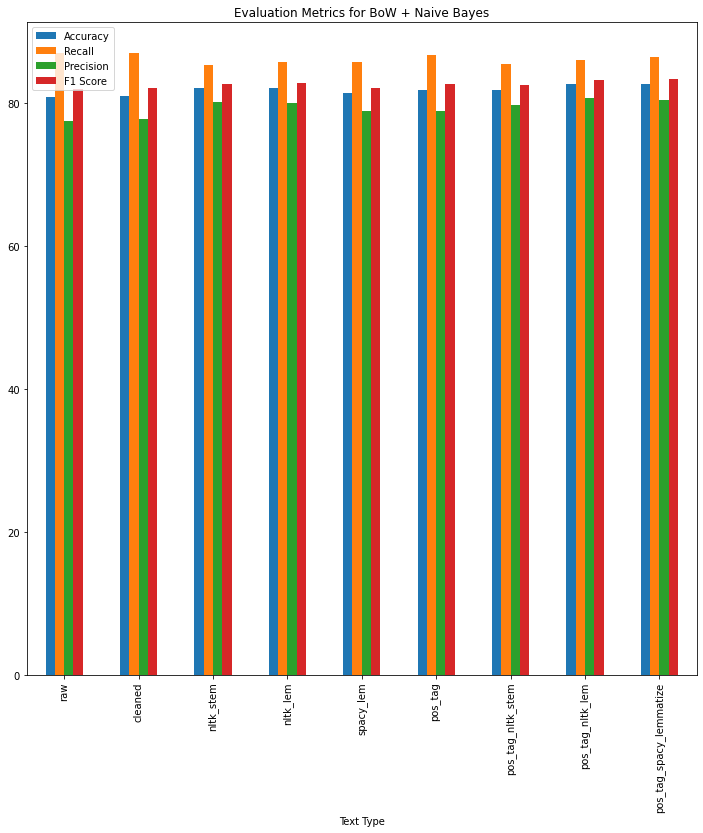

In [6]:
measures = ["Text Type", "Accuracy", "Recall", "Precision", "F1 Score"]
data = []
for column in df.columns[3:]:
    count_vec = CountVectorizer()
    bow = count_vec.fit_transform(df[column])
    bow = np.array(bow.todense())

    X = bow
    y = list(df['sentiment'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    model = MultinomialNB().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred, average="binary", pos_label="1")*100, 2)
    precision = round(precision_score(y_test, y_pred, average='binary', pos_label="1")*100, 2)
    f1 = round(f1_score(y_test, y_pred, average='binary', pos_label="1")*100, 2)
    data.append([column, accuracy, recall, precision, f1])
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title(str('Confusion Matrix for '+column), fontsize=12)
    plt.show()

presentation_df = pd.DataFrame(data, columns=measures) 
presentation_df.plot(x="Text Type", kind='bar', figsize= (12, 12), stacked=False, title='Evaluation Metrics for BoW + Naive Bayes')
display(presentation_df)

#### Count Vectorizer (Bag of Words) Logistic Regression Classification

By keeping the vectorizer the same and checking this classifier against another well-established classifier called logistic regression, we can see that the baseline model has been improved here. All statistics hover around the 85% mark and in general beat MNB. From a high-level perspective, this makes sense: MNB is a probabilistic model and logistic regression is a linear model. Both use different equations to model whether an item belongs to a certain class. These being: 

-	P(class | features) = P(features | class) * P(class) / P(features) for MNB
-	P(class | features) = 1 / (1 + exp(-z)) for logistic regression

In this scenario, where input data is highly correlated (as negative words often indicate more negative words are to follow and vice versa), the independence assumption of Naïve Bayes (as clarified before) does not hold, which limits the accuracy of the baseline model to the rough 80% mark. As expected, PoS tagged results have a slightly higher score in accuracy. 

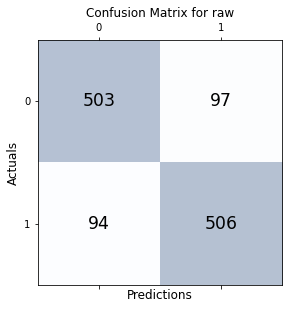

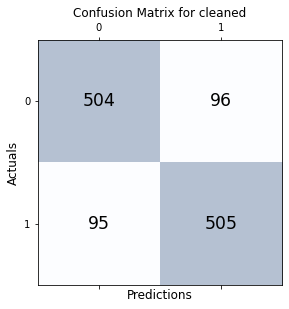

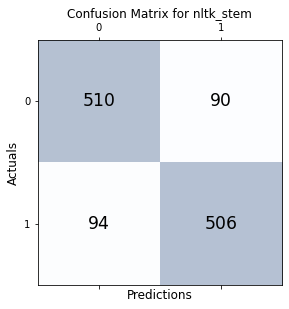

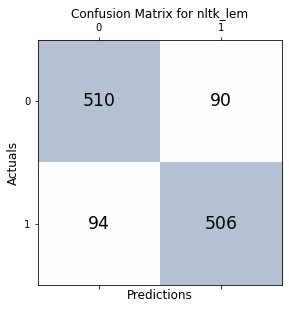

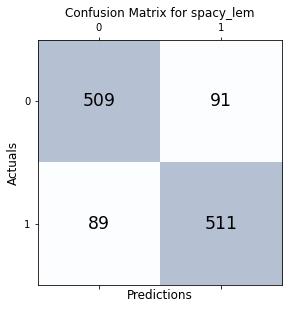

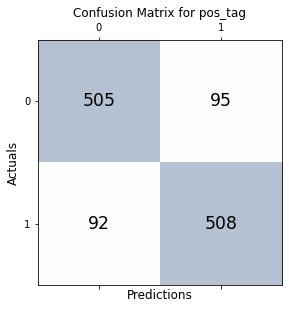

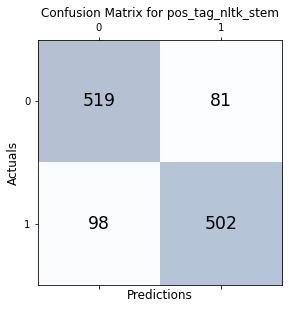

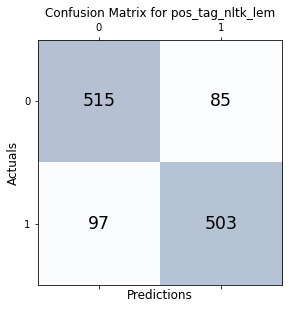

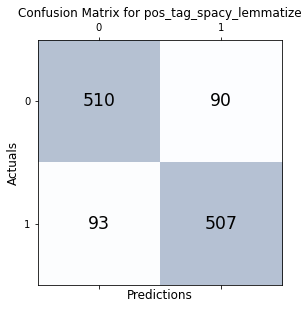

,Text Type,Accuracy,Recall,Precision,F1 Score
0,raw,84.08,84.33,83.91,84.12
1,cleaned,84.08,84.17,84.03,84.10
2,nltk_stem,84.67,84.33,84.90,84.62
3,nltk_lem,84.67,84.33,84.90,84.62
4,spacy_lem,85.00,85.17,84.88,85.02
5,pos_tag,84.42,84.67,84.25,84.46
6,pos_tag_nltk_stem,85.08,83.67,86.11,84.87
7,pos_tag_nltk_lem,84.83,83.83,85.54,84.68
8,pos_tag_spacy_lemmatize,84.75,84.50,84.92,84.71


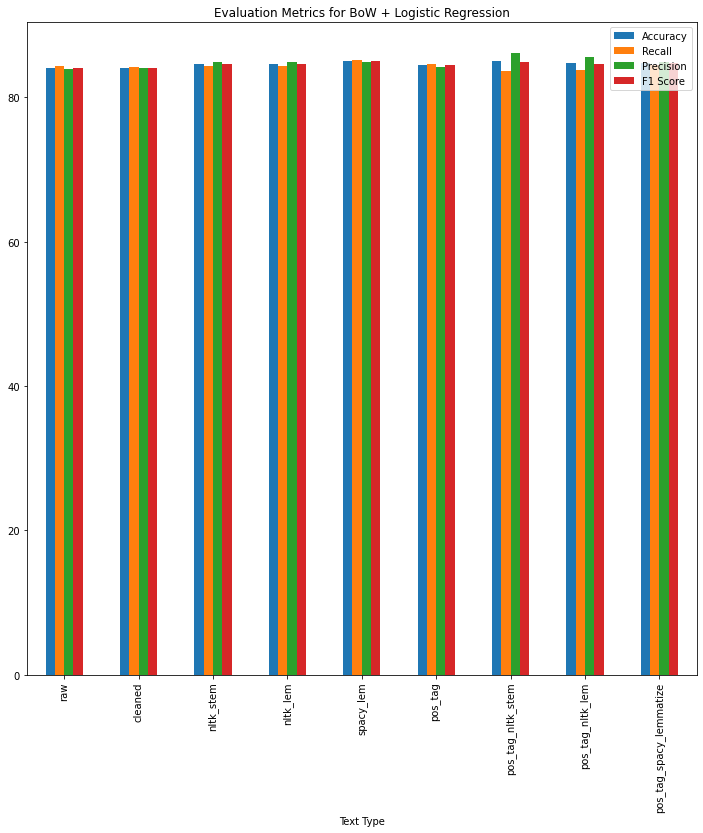

In [7]:
data = []
for column in df.columns[3:]:
    count_vec = CountVectorizer()
    bow = count_vec.fit_transform(df[column])
    bow = np.array(bow.todense())

    X = bow
    y = list(df['sentiment'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    model = LogisticRegression(solver='liblinear').fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred, average="binary", pos_label="1")*100, 2)
    precision = round(precision_score(y_test, y_pred, average='binary', pos_label="1")*100, 2)
    f1 = round(f1_score(y_test, y_pred, average='binary', pos_label="1")*100, 2)
    conf_matrix = confusion_matrix(y_test, y_pred)
    data.append([column, accuracy, recall, precision, f1])
    
    
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title(str('Confusion Matrix for '+column), fontsize=12)
    plt.show()
    
presentation_df = pd.DataFrame(data, columns=measures) 
presentation_df.plot(x="Text Type", kind='bar', figsize= (12, 12), stacked=False, title='Evaluation Metrics for BoW + Logistic Regression')
display(presentation_df)

#### Simple Neural Network with Glove

To further explore the topic, we have also chosen another baseline, this time for neural networks. A “Dense” layer is one of the most common layers in a neural model, so just one layer has been entered by itself as part of the output layer, alongside the glove embedding layer. It has a generally good accuracy of 70% overall, also reflects the benefits of PoS tagging. Interestingly, the cleaned text has a lower accuracy when compared to the raw text, implying that some “meaning”, or more likely dimensionality, was being removed after the process. 

It seems that in neural networks, lemmatising has a great benefit, while stemming has decreased the scores. Stemming is a simple and fast technique that truncates words without caring for the meaning of what is being shortened, and as a result it can make text less accurate and legible in some cases- which justifies the low score of 60.17% as compared to 63.42% for just the raw text. Lemmatisation, on the other hand is more sophisticated and reduces words to their base forms, so words like “better” are transformed into “good”. While being more time-consuming, it produces better results- in this case it has boosted them by roughly 9%. F-scores, being a harmonic mean of both precision and recall, show that PoS tagging has helped with these statistics too, adding a minor percentage to each statistic (ignoring the erroneous data of stemming). 

If one were to compare the baselines to each other, neural networks has been inferior in this case. From papers read, there are many factors to blame for this: one of which being the size of input data. Across multiple papers, as many as 10,000 individual reviews have been used whereas here we have 4,000. Another clue is that naïve bayes is built for classification, whereas neural networks are more general purpose and are more susceptible to noise in data (which can be said about this dataset) and as such, require more training. The assumptions that naïve bayes makes, while usually untrue, can sometimes hold also leading to better results. 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          3288700   
                                                                 
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_1 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 3,298,701
Trainable params: 10,001
Non-trainable params: 3,288,700
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.7462 - acc: 0.5268 - val_loss: 0.6933 - val_acc: 0.5768
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5806 - acc: 0.6960 - val_loss: 0.6694 - val_acc: 0.5893
Epoch 3/7
18/18 [=======================

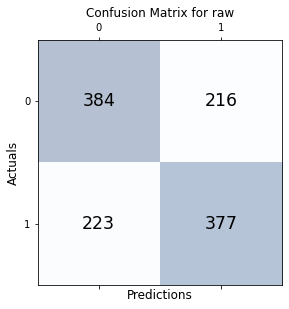

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2979500   
                                                                 
 flatten_2 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 2,989,501
Trainable params: 10,001
Non-trainable params: 2,979,500
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 10ms/step - loss: 0.7888 - acc: 0.5045 - val_loss: 0.6919 - val_acc: 0.5804
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.6210 - acc: 0.6540 - val_loss: 0.7337 - val_acc: 0.5536
Epoch 3/7
18/18 [======================

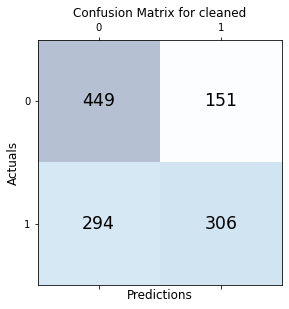

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          1670300   
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_3 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 1,680,301
Trainable params: 10,001
Non-trainable params: 1,670,300
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 11ms/step - loss: 0.7274 - acc: 0.5179 - val_loss: 0.7154 - val_acc: 0.5429
Epoch 2/7
18/18 [==============================] - 0s 5ms/step - loss: 0.5381 - acc: 0.7571 - val_loss: 0.7026 - val_acc: 0.5696
Epoch 3/7
18/18 [======================

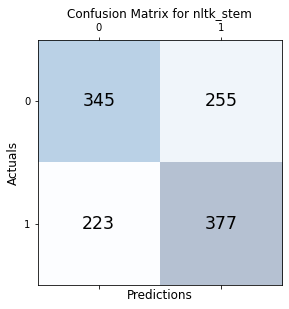

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          2651900   
                                                                 
 flatten_4 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 2,661,901
Trainable params: 10,001
Non-trainable params: 2,651,900
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.7074 - acc: 0.5491 - val_loss: 0.6389 - val_acc: 0.6411
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5293 - acc: 0.7500 - val_loss: 0.5983 - val_acc: 0.6679
Epoch 3/7
18/18 [=======================

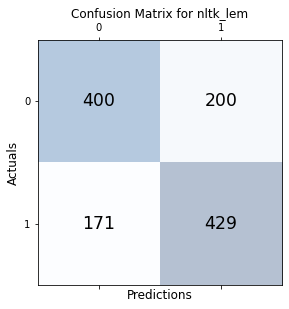

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          2374800   
                                                                 
 flatten_5 (Flatten)         (None, 10000)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 2,384,801
Trainable params: 10,001
Non-trainable params: 2,374,800
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.7009 - acc: 0.5607 - val_loss: 0.6673 - val_acc: 0.5893
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5160 - acc: 0.7790 - val_loss: 0.6241 - val_acc: 0.6643
Epoch 3/7
18/18 [=======================

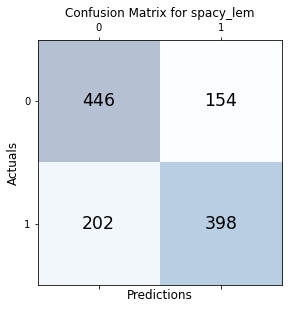

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 100)          2958300   
                                                                 
 flatten_6 (Flatten)         (None, 10000)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 2,968,301
Trainable params: 10,001
Non-trainable params: 2,958,300
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.7032 - acc: 0.5585 - val_loss: 0.6575 - val_acc: 0.6143
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5222 - acc: 0.7567 - val_loss: 0.6229 - val_acc: 0.6446
Epoch 3/7
18/18 [=======================

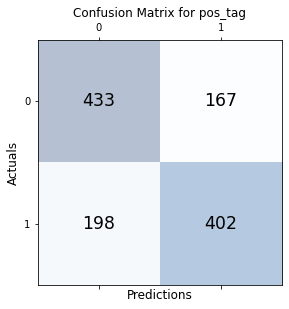

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 100)          1652500   
                                                                 
 flatten_7 (Flatten)         (None, 10000)             0         
                                                                 
 dense_7 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 1,662,501
Trainable params: 10,001
Non-trainable params: 1,652,500
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.7238 - acc: 0.5192 - val_loss: 0.7119 - val_acc: 0.5446
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5411 - acc: 0.7737 - val_loss: 0.6943 - val_acc: 0.5768
Epoch 3/7
18/18 [=======================

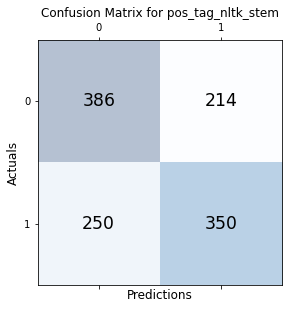

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 100)          2632700   
                                                                 
 flatten_8 (Flatten)         (None, 10000)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 2,642,701
Trainable params: 10,001
Non-trainable params: 2,632,700
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.6946 - acc: 0.5670 - val_loss: 0.6557 - val_acc: 0.6214
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5202 - acc: 0.7589 - val_loss: 0.6240 - val_acc: 0.6321
Epoch 3/7
18/18 [=======================

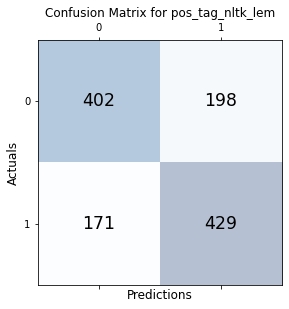

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 100, 100)          2389600   
                                                                 
 flatten_9 (Flatten)         (None, 10000)             0         
                                                                 
 dense_9 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 2,399,601
Trainable params: 10,001
Non-trainable params: 2,389,600
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 0s 9ms/step - loss: 0.7034 - acc: 0.5504 - val_loss: 0.6512 - val_acc: 0.6125
Epoch 2/7
18/18 [==============================] - 0s 4ms/step - loss: 0.5177 - acc: 0.7621 - val_loss: 0.6171 - val_acc: 0.6536
Epoch 3/7
18/18 [=======================

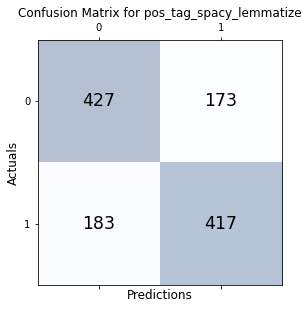

,Text Type,Accuracy,Recall,Precision,F1 Score
0,raw,63.42,62.83,63.58,63.20
1,cleaned,62.92,51.00,66.96,57.90
2,nltk_stem,60.17,62.83,59.65,61.20
3,nltk_lem,69.08,71.50,68.20,69.81
4,spacy_lem,70.33,66.33,72.10,69.10
5,pos_tag,69.58,67.00,70.65,68.78
6,pos_tag_nltk_stem,61.33,58.33,62.06,60.14
7,pos_tag_nltk_lem,69.25,71.50,68.42,69.93
8,pos_tag_spacy_lemmatize,70.33,69.50,70.68,70.08


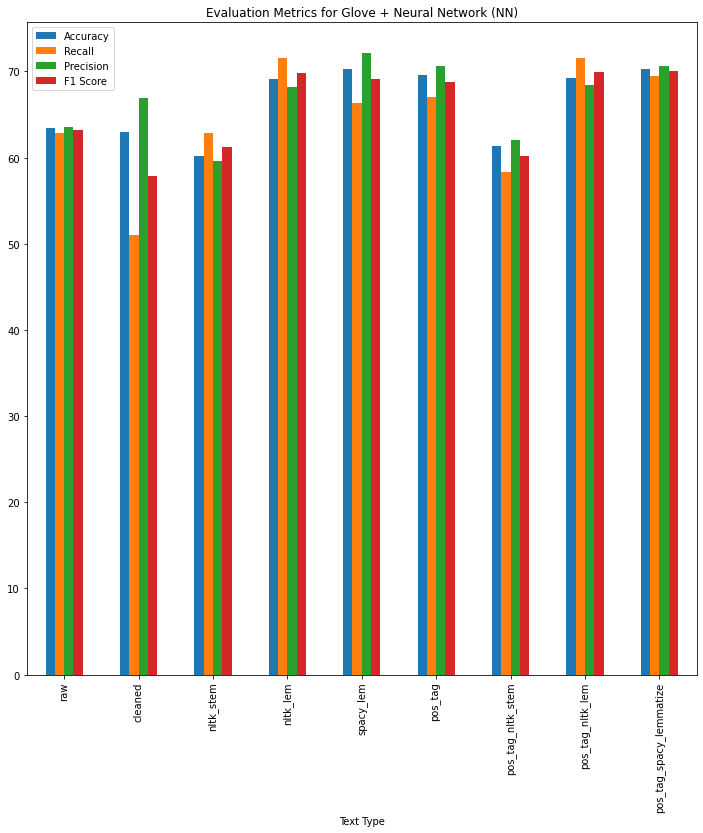

In [9]:
data = []
for column in df.columns[3:]:
    X = df[column]
    y = df['sentiment']

    lb = LabelEncoder()
    y = lb.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    embeddings_dictionary = dict()
    glove_file = open('C:/Users/vedan/glove.6B/glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    print(model.summary())
    
    history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.2)
    
    y_pred = model.predict(X_test).round()
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred, average="binary", pos_label=1)*100, 2)
    precision = round(precision_score(y_test, y_pred, average='binary', pos_label=1)*100, 2)
    f1 = round(f1_score(y_test, y_pred, average='binary', pos_label=1)*100, 2)
    data.append([column, accuracy, recall, precision, f1])
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title(str('Confusion Matrix for '+column), fontsize=12)
    plt.show()

presentation_df = pd.DataFrame(data, columns=measures) 
presentation_df.plot(x="Text Type", kind='bar', figsize= (12, 12), stacked=False, title='Evaluation Metrics for Glove + Neural Network (NN)')
display(presentation_df)

#### 1D Convolutional Neural Network with Glove

To provide an alternative to this baseline, along with the dense layer, a convolution layer consisting of 128 neurons was added along with a pooling layer. This makes the model a convolutional neural network- a type of network usually used for classification of images and grid style information. This boosted accuracy by 10%, indicating that the baseline has been improved. The results suggest that the CNN is able to perform better because it is already able to extract and process features, such as phrasings and terms, from relatively noisy data already, whereas the simple neural network needs features and tuning of pre-processing to produce a good result. 

The F-score has been increased by 15% between the baseline and alternative. This can be attributed to the additional hidden layer: having more neurons available to represent the input data helps with marking sentiment- the simple neural network was limited by its neuron count and was not able to store such information. The pooling layer added reduced the dimensionality of the data and improved generalisation. This was not available to the simple neural network and so it most likely overfitted the data, returning with bad recall and precision. 

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 100, 100)          3288700   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,352,957
Trainable params: 64,257
Non-trainable params: 3,288,700
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 29ms/step - loss: 0.6848 - acc: 0.5844 - val_

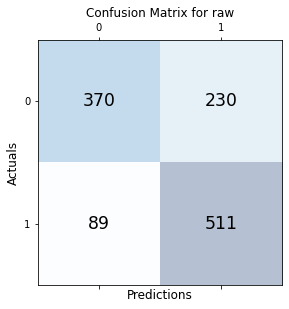

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 100, 100)          2979500   
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_11 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,043,757
Trainable params: 64,257
Non-trainable params: 2,979,500
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 27ms/step - loss: 0.6670 - acc: 0.5978 - val_

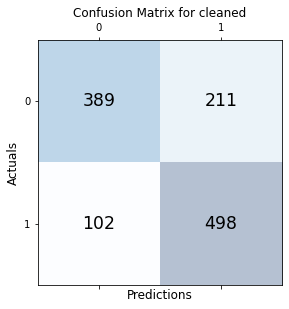

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 100, 100)          1670300   
                                                                 
 conv1d_2 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,734,557
Trainable params: 64,257
Non-trainable params: 1,670,300
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 26ms/step - loss: 0.7351 - acc: 0.5232 - val_

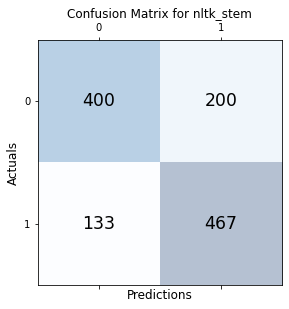

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 100, 100)          2651900   
                                                                 
 conv1d_3 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_13 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,716,157
Trainable params: 64,257
Non-trainable params: 2,651,900
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 28ms/step - loss: 0.8985 - acc: 0.5165 - val_

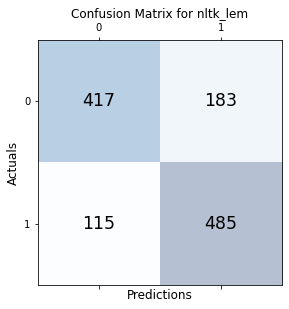

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, 100, 100)          2374800   
                                                                 
 conv1d_4 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_4 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_14 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,439,057
Trainable params: 64,257
Non-trainable params: 2,374,800
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 43ms/step - loss: 0.7430 - acc: 0.5464 - val_

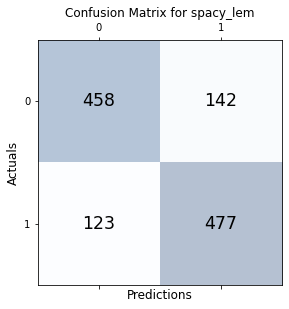

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 100, 100)          2958300   
                                                                 
 conv1d_5 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_5 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_15 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,022,557
Trainable params: 64,257
Non-trainable params: 2,958,300
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 41ms/step - loss: 0.6836 - acc: 0.5911 - val_

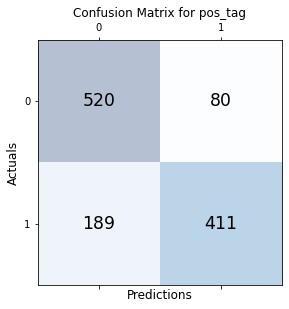

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 100, 100)          1652500   
                                                                 
 conv1d_6 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,716,757
Trainable params: 64,257
Non-trainable params: 1,652,500
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 41ms/step - loss: 0.6909 - acc: 0.5397 - val_

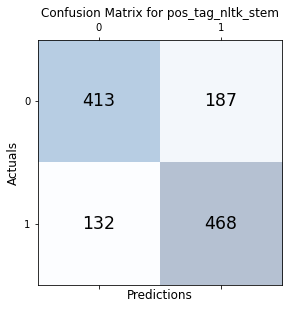

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_17 (Embedding)    (None, 100, 100)          2632700   
                                                                 
 conv1d_7 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_7 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_17 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,696,957
Trainable params: 64,257
Non-trainable params: 2,632,700
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 39ms/step - loss: 0.7195 - acc: 0.5437 - val_

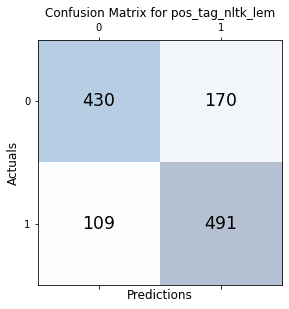

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 100, 100)          2389600   
                                                                 
 conv1d_8 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_8 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_18 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,453,857
Trainable params: 64,257
Non-trainable params: 2,389,600
_________________________________________________________________
None
Epoch 1/7
18/18 [==============================] - 1s 39ms/step - loss: 0.6918 - acc: 0.5763 - val_

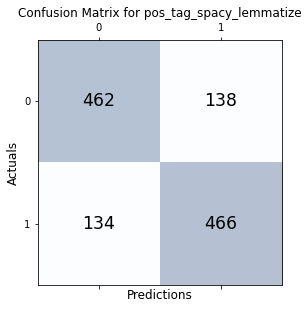

,Text Type,Accuracy,Recall,Precision,F1 Score
0,raw,73.42,85.17,68.96,76.21
1,cleaned,73.92,83.00,70.24,76.09
2,nltk_stem,72.25,77.83,70.01,73.72
3,nltk_lem,75.17,80.83,72.60,76.50
4,spacy_lem,77.92,79.50,77.06,78.26
5,pos_tag,77.58,68.50,83.71,75.34
6,pos_tag_nltk_stem,73.42,78.00,71.45,74.58
7,pos_tag_nltk_lem,76.75,81.83,74.28,77.87
8,pos_tag_spacy_lemmatize,77.33,77.67,77.15,77.41


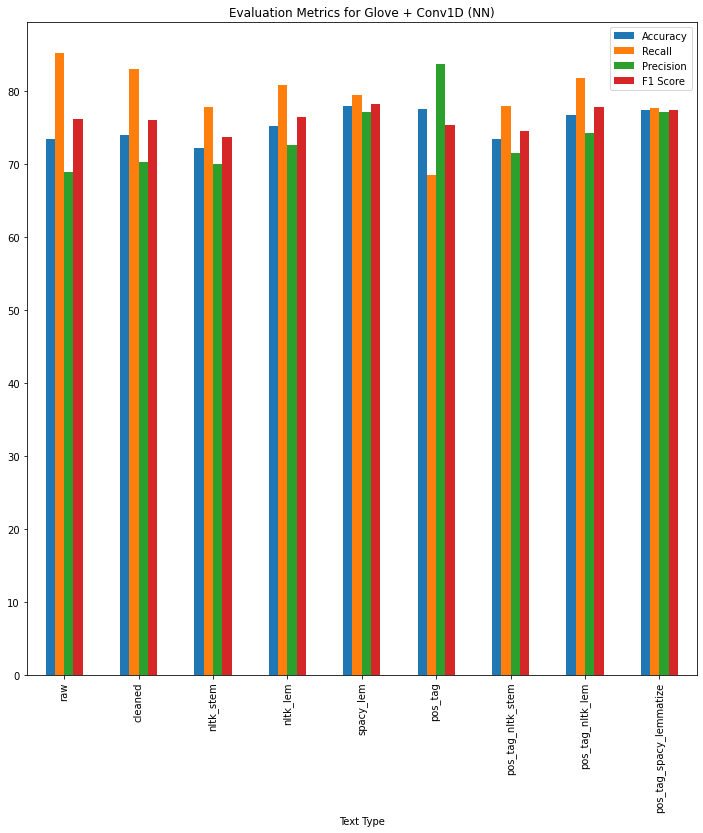

In [10]:
data = []
for column in df.columns[3:]:
    X = df[column]
    y = df['sentiment']

    lb = LabelEncoder()
    y = lb.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    embeddings_dictionary = dict()
    glove_file = open('C:/Users/vedan/glove.6B/glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    # Convolutional Neural Network
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
    model.add(embedding_layer)
    model.add(Conv1D(128, 5, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(1, activation='sigmoid'))
    
#     model.add(embedding_layer)
#     model.add(MaxPooling1D(3))
#     model.add(Conv1D(128, 3, activation='relu'))
#     model.add(MaxPooling1D(3))
#     model.add(Conv1D(128, 3, activation='relu'))
#     # model.add(MaxPooling1D(35)) # global max pooling
#     model.add(Flatten())
#     model.add(Dense(128, activation='relu'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    
    print(model.summary())
    
    history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.2)

#     score = model.evaluate(X_test, y_test, verbose=1)
    
    y_pred = model.predict(X_test).round()
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred, average="binary", pos_label=1)*100, 2)
    precision = round(precision_score(y_test, y_pred, average='binary', pos_label=1)*100, 2)
    f1 = round(f1_score(y_test, y_pred, average='binary', pos_label=1)*100, 2)
    data.append([column, accuracy, recall, precision, f1])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title(str('Confusion Matrix for '+column), fontsize=12)
    plt.show()
presentation_df = pd.DataFrame(data, columns=measures) 
presentation_df.plot(x="Text Type", kind='bar', figsize= (12, 12), stacked=False, title='Evaluation Metrics for Glove + Conv1D (NN)')
display(presentation_df)

#### LSTM (Recurrent Neural Network) with Glove Vectoriser

As an extension to this work, an LSTM (long short term memory) neural model was created. Returned results were slightly lower than the CNN model provided earlier which prompts further investigation (67.5% vs 73.92% for cleaned text). The model is still better than the baseline defined for it, as it holds an average accuracy of roughly 70%, but leaves much to be desired. LSTMs are designed for recording long term dependencies within data, i.e., context as the sentiment of a word can depend on the previous series of words. The F-scores also reflect its position between CNN and baseline. 

32887
Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, 100, 100)          3288700   
                                                                 
 lstm_18 (LSTM)              (None, 128)               117248    
                                                                 
 dense_37 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,406,077
Trainable params: 117,377
Non-trainable params: 3,288,700
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 5s 220ms/step - loss: 0.6983 - acc: 0.5186 - val_loss: 0.6739 - val_acc: 0.5945
Epoch 2/7
16/16 [==============================] - 3s 205ms/step - loss: 0.6646 - acc: 0.6223 - val_loss: 0.6353 - val_acc: 0.6766
Epoch 3/7
16/16 [===========

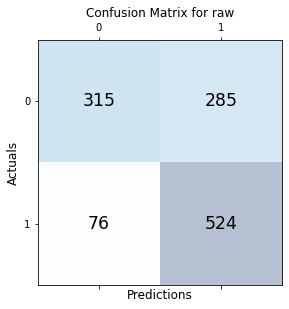

29795
Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, 100, 100)          2979500   
                                                                 
 lstm_19 (LSTM)              (None, 128)               117248    
                                                                 
 dense_38 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,096,877
Trainable params: 117,377
Non-trainable params: 2,979,500
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 5s 257ms/step - loss: 0.6938 - acc: 0.5324 - val_loss: 0.6722 - val_acc: 0.5898
Epoch 2/7
16/16 [==============================] - 5s 322ms/step - loss: 0.6562 - acc: 0.6233 - val_loss: 0.6074 - val_acc: 0.6837
Epoch 3/7
16/16 [===========

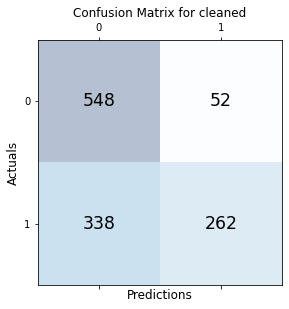

16703
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, 100, 100)          1670300   
                                                                 
 lstm_20 (LSTM)              (None, 128)               117248    
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,787,677
Trainable params: 117,377
Non-trainable params: 1,670,300
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 6s 323ms/step - loss: 0.6942 - acc: 0.5130 - val_loss: 0.6905 - val_acc: 0.5030
Epoch 2/7
16/16 [==============================] - 5s 329ms/step - loss: 0.6702 - acc: 0.5896 - val_loss: 0.6682 - val_acc: 0.6195
Epoch 3/7
16/16 [===========

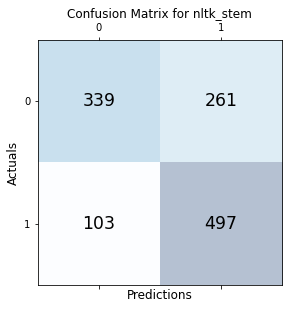

26519
Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 100, 100)          2651900   
                                                                 
 lstm_21 (LSTM)              (None, 128)               117248    
                                                                 
 dense_40 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,769,277
Trainable params: 117,377
Non-trainable params: 2,651,900
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 11s 585ms/step - loss: 0.6889 - acc: 0.5130 - val_loss: 0.6771 - val_acc: 0.5517
Epoch 2/7
16/16 [==============================] - 9s 559ms/step - loss: 0.6502 - acc: 0.6401 - val_loss: 0.6262 - val_acc: 0.6528
Epoch 3/7
16/16 [==========

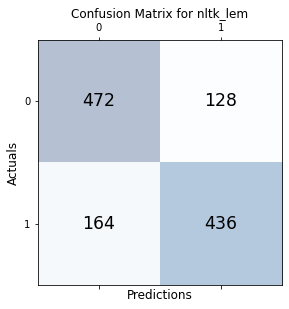

23748
Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 100, 100)          2374800   
                                                                 
 lstm_22 (LSTM)              (None, 128)               117248    
                                                                 
 dense_41 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,492,177
Trainable params: 117,377
Non-trainable params: 2,374,800
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 11s 596ms/step - loss: 0.6850 - acc: 0.5299 - val_loss: 0.6779 - val_acc: 0.5375
Epoch 2/7
16/16 [==============================] - 9s 557ms/step - loss: 0.6434 - acc: 0.6258 - val_loss: 0.5802 - val_acc: 0.7277
Epoch 3/7
16/16 [==========

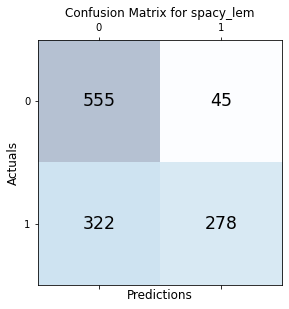

29583
Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_33 (Embedding)    (None, 100, 100)          2958300   
                                                                 
 lstm_23 (LSTM)              (None, 128)               117248    
                                                                 
 dense_42 (Dense)            (None, 1)                 129       
                                                                 
Total params: 3,075,677
Trainable params: 117,377
Non-trainable params: 2,958,300
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 11s 575ms/step - loss: 0.6810 - acc: 0.5559 - val_loss: 0.6630 - val_acc: 0.5910
Epoch 2/7
16/16 [==============================] - 9s 567ms/step - loss: 0.6245 - acc: 0.6723 - val_loss: 0.6172 - val_acc: 0.7015
Epoch 3/7
16/16 [==========

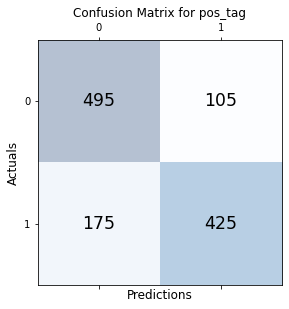

16525
Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, 100, 100)          1652500   
                                                                 
 lstm_24 (LSTM)              (None, 128)               117248    
                                                                 
 dense_43 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1,769,877
Trainable params: 117,377
Non-trainable params: 1,652,500
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 10s 562ms/step - loss: 0.6915 - acc: 0.5135 - val_loss: 0.6880 - val_acc: 0.5208
Epoch 2/7
16/16 [==============================] - 9s 548ms/step - loss: 0.6727 - acc: 0.5666 - val_loss: 0.6760 - val_acc: 0.6124
Epoch 3/7
16/16 [==========

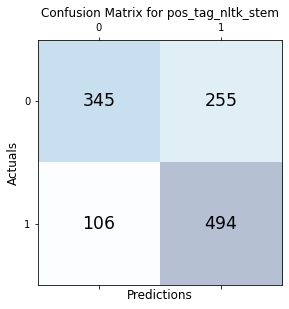

26327
Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_35 (Embedding)    (None, 100, 100)          2632700   
                                                                 
 lstm_25 (LSTM)              (None, 128)               117248    
                                                                 
 dense_44 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,750,077
Trainable params: 117,377
Non-trainable params: 2,632,700
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 11s 598ms/step - loss: 0.6868 - acc: 0.5278 - val_loss: 0.6854 - val_acc: 0.5232
Epoch 2/7
16/16 [==============================] - 9s 559ms/step - loss: 0.6707 - acc: 0.5636 - val_loss: 0.6804 - val_acc: 0.5791
Epoch 3/7
16/16 [==========

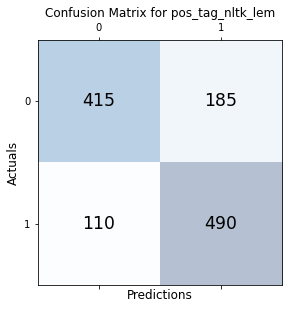

23896
Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_36 (Embedding)    (None, 100, 100)          2389600   
                                                                 
 lstm_26 (LSTM)              (None, 128)               117248    
                                                                 
 dense_45 (Dense)            (None, 1)                 129       
                                                                 
Total params: 2,506,977
Trainable params: 117,377
Non-trainable params: 2,389,600
_________________________________________________________________
None
Epoch 1/7
16/16 [==============================] - 11s 635ms/step - loss: 0.6892 - acc: 0.5166 - val_loss: 0.6812 - val_acc: 0.5589
Epoch 2/7
16/16 [==============================] - 10s 608ms/step - loss: 0.6513 - acc: 0.6172 - val_loss: 0.6523 - val_acc: 0.6671
Epoch 3/7
16/16 [=========

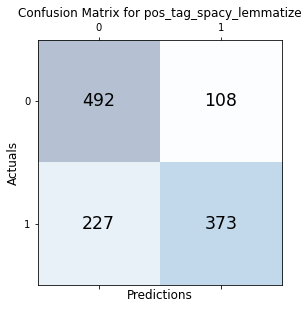

,Text Type,Accuracy,Recall,Precision,F1 Score
0,raw,69.92,87.33,64.77,74.38
1,cleaned,67.50,43.67,83.44,57.33
2,nltk_stem,69.67,82.83,65.57,73.20
3,nltk_lem,75.67,72.67,77.30,74.91
4,spacy_lem,69.42,46.33,86.07,60.24
5,pos_tag,76.67,70.83,80.19,75.22
6,pos_tag_nltk_stem,69.92,82.33,65.95,73.24
7,pos_tag_nltk_lem,75.42,81.67,72.59,76.86
8,pos_tag_spacy_lemmatize,72.08,62.17,77.55,69.01


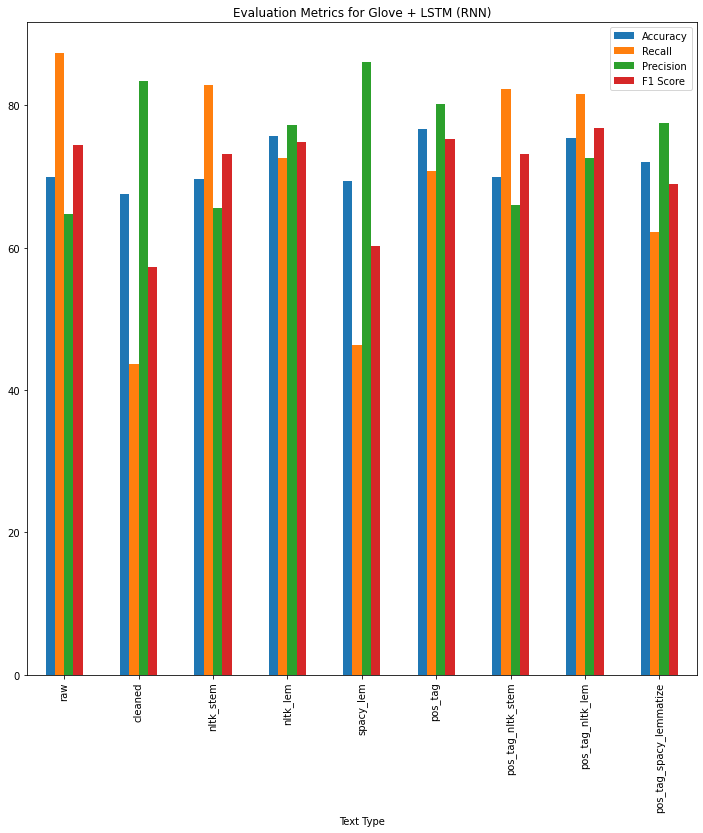

In [12]:
data = []
for column in df.columns[3:]:
    X = df[column]
    y = df['sentiment']

    lb = LabelEncoder()
    y = lb.fit_transform(y)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(X_train)

    X_train = tokenizer.texts_to_sequences(X_train)
    X_test = tokenizer.texts_to_sequences(X_test)

    vocab_size = len(tokenizer.word_index) + 1

    maxlen = 100

    X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
    X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

    print(vocab_size)

    embeddings_dictionary = dict()
    glove_file = open('C:/Users/vedan/glove.6B/glove.6B.100d.txt', encoding="utf8")

    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    glove_file.close()

    embedding_matrix = zeros((vocab_size, 100))
    for word, index in tokenizer.word_index.items():
        embedding_vector = embeddings_dictionary.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

    # LSTM Neural Network
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)
    # model.add(Conv1D(3, 3, activation='relu'))
#     model.add(Bidirectional(LSTM(2, dropout=0.2, return_sequences=True)))
#     model.add(Bidirectional(LSTM(3, dropout=0.2, return_sequences=True)))
#     model.add(Dense(2))
#     model.add(Flatten())
    model.add(LSTM(128))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

    print(model.summary())
    
    # For comparison with other neural models
    # history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.2)
    
    # Optimised neural model 
    history = model.fit(X_train, y_train, batch_size=128, epochs=7, verbose=1, validation_split=0.3, callbacks=my_callbacks)
    
#     score = model.evaluate(X_test, y_test, verbose=1)
    
    y_pred = model.predict(X_test).round()
    
    accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
    recall = round(recall_score(y_test, y_pred, average="binary", pos_label=1)*100, 2)
    precision = round(precision_score(y_test, y_pred, average='binary', pos_label=1)*100, 2)
    f1 = round(f1_score(y_test, y_pred, average='binary', pos_label=1)*100, 2)
    data.append([column, accuracy, recall, precision, f1])
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(4.5, 4.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=12)
    plt.ylabel('Actuals', fontsize=12)
    plt.title(str('Confusion Matrix for '+column), fontsize=12)
    plt.show()
    
presentation_df = pd.DataFrame(data, columns=measures) 
presentation_df.plot(x="Text Type", kind='bar', figsize= (12, 12), stacked=False, title='Evaluation Metrics for Glove + LSTM (RNN)')
display(presentation_df)

## Final Notes

The code was limited by time and resources in this case- models such as Random Forest and BERT were contemplated but later scrapped due to time constraints. 

Given more time, ideas such as C_LSTM and Bidirectional layers combined with multiple hidden networks for LSTM could have improved scores across the board, but this would have required a significant amount of time to test. With better processor speeds, results could have been obtained quicker too. 

Overall, this study has been insightful and illustrated parallels between lecture content and practical uses. 